##### Версия 0.1 -- Март 2018

# Метод зеркального отражения

На предыдущих занятиях курса _AeroPython_ как при помощи комбинации элементарных потенциальных решений можно получить картины линий тока, описывающие течение вокруг некоторых объектов, например [овала Рэнкина](02_Lesson02_sourceSinkFreestream.ipynb) или [кругового цилиндра](03_Lesson03_doublet.ipynb).

Вы спросите, а можно ли воспроизвести обтекание плоской поверхности? Да, можно!

Коротко, метод зеркального отражения заключается в следующем: поместим особенность рядом со "стенкой", добавив "отражение" этой особенности по другую сторону от стенки.
Иногда такой подход называют "аэродинамической интерференцией".

Кроме того, этот блокнот также дает нам возможность ввести понятие **классов** в Python. Это очень полезный способ организовать ваш код, который становится по-настоящему необходимым по мере того, как программы становятся сложнее.

Как обычно, мы начнем с импорта библиотек и создании расчетной сетки. И быстренько разберемся со всем этим.

In [1]:
import numpy
import math
from matplotlib import pyplot
# помещаем графику внутрь блокнота
%matplotlib inline

In [2]:
N = 50                                # Число точек в каждом направлении
x_start, x_end = -2.0, 2.0            # граница по x
y_start, y_end = -1.0, 1.0            # граница по y
x = numpy.linspace(x_start, x_end, N)    # вычисляем одномерный массив x
y = numpy.linspace(y_start, y_end, N)    # вычисляем одномерный массив y
X, Y = numpy.meshgrid(x, y)              # создаем расчетную сетку

## Источник вблизи плоской поверхности

Если расположить источник вблизи поверхности, то эта поверхность внесет возмущения в течение. Представим, что источник расположен в точке $y=y_\text{source}$ вблизи поверхности $y=0$. Для выполнения граничного условия на поверхности нужно, чтобы поток был ей параллелен, для горизонтальной плоскости это означает, что на стенке $v=0$. Стенка оказывает на течение от источника такое же воздействие, как и равный по интенсивности источник (отражение), расположенный в точке $y=-y_\text{source}$.

Ок, теперь настало время стать хитрее и перестать множить код, тратя наше драгоценное время! В предыдущем блокноте мы уже ввели понятие функции в Python, а теперь пора двигаться дальше и познакомиться с  **классами**.

Класс — это набор данных (параметры и переменные) и "методов" или функций, которые работают с этими данными. Это очень аккуратный способ организации кода. По мере создания больших объемов и усложнения кода, это помогает нам справиться со сложностями. Код будет легче поддерживать, изменять и расширять.

Мы определим класс под названием `Source`, который будет содержать информацию, относящуюся к источнику. Такие особенности, как источник, определяются интенсивностью и положением в расчетной области. Поэтому у нашего класса `Source` будут три `атрибута`:

* `strength`: интенсивность источника.
* `x`: $x$-координата положения источника.
* `y`: $y$-координата положения источника.

Что бы мы хотели сделать после определения нашего источника? Мы бы хотели вычислить поле скоростей, а также функцию тока. Таким образом, в нашем классе нужно реализовать два метода (функции, принадлежащие классу): для вычисления скорости (функция `velocity`) и функции тока (функция `stream_function`).

Давайте рассмотим их подробнее:

* метод `velocity`: это функция для расчета скорости, порождаемой источником, в узлах сетки (`X`,`Y`). Поэтому у этого метода будет два аргумента, `X` и `Y`, и он будет создавать два новых атрибута источника: компоненты скорости `u` и `v`.
* метод `stream_function`: это функция для вычисления функции тока порождаемой источником, в узлах сетки (`X`,`Y`). Поэтому у этого метода будет два аргумента, `X` и `Y`, и он будет создавать один новый атрибут источника: `psi`, функцию тока.

Помимо этих двух методов, у каждого класса есть *конструктор*. По сути, это способ инициализации данных. Это функция, которая всегда называется `__init__`:

In [3]:
class Source:
    """
    Contains information related to a source (or sink).
    """
    def __init__(self, strength, x, y):
        """
        Sets the location and strength of the singularity.
        
        Parameters
        ----------
        strength: float
            Strength of the singularity.
        x: float
            x-coordinate of the singularity.
        y: float
            y-coordinate of the singularity.
        """
        self.strength = strength
        self.x, self.y = x, y
    
    def velocity(self, X, Y):
        """
        Computes the velocity field generated by the singularity.
        
        Parameters
        ----------
        X: 2D Numpy array of floats
            x-coordinate of the mesh points.
        Y: 2D Numpy array of floats
            y-coordinate of the mesh points.
        """
        self.u = self.strength/(2*math.pi)*(X-self.x)/((X-self.x)**2+\
                                                       (Y-self.y)**2)
        self.v = self.strength/(2*math.pi)*(Y-self.y)/((X-self.x)**2+\
                                                       (Y-self.y)**2)
    
    def stream_function(self, X, Y):
        """
        Computes the stream-function generated by the singularity.
        
        Parameters
        ----------
        X: 2D Numpy array of floats
            x-coordinate of the mesh points.
        Y: 2D Numpy array of floats
            y-coordinate of the mesh points.
        """
        self.psi = self.strength/(2*math.pi)*numpy.arctan2((Y-self.y), \
                                                           (X-self.x))

А для чего нужен `self`? Создание объекта класса `Source` выглядит как вызов функции. Например: `source = Source(1, 0, 0)` создаст источник интенсивностью 1, расположенный в начале координат. Python автоматически вызывает функцию *constructor*  с параметрами `(self, 1, 0, 0)`, т.е. интерпретатор добавляет `self` в список параметров, что означает "источник, который должен быть создан сейчас с такими параметрами".

Как только мы создали `source`, можно вызвать два метода для вычисления поля скоростей и функции тока на сетке (`X`,`Y`). Как и при использовании библиотек, мы укажем на метод класса с помощью точечной нотации (как показано ниже).

Компоненты скорости в декартовой системе координат:

$$u = \frac{\sigma}{2\pi}\frac{x-x_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

$$v = \frac{\sigma}{2\pi}\frac{y-y_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

а функция тока записывается в виде:

$$\psi = \frac{\sigma}{2\pi}\arctan\left(\frac{y-y_\text{source}}{x-x_\text{source}}\right)$$

Теперь давайте посмотрим, как это работает.

In [4]:
strength_source = 1.0                  # интенсивность источника       
x_source, y_source = 0.0, 0.5          # положение источника

# создаем источник (объект класса Source) 
source = Source(strength_source, x_source, y_source)

# вычисляем поле скорости и функцию тока для источника
# в узлах расчетной сетки
source.velocity(X, Y)
source.stream_function(X, Y)

Обратили внимание на точку? Используя ее, мы говорим: "возьми функцию `velocity` объекта `source`, который мы только что создали, и выполнить ее." Как можно убедиться, функция `velocity` связана с данными конкретного источника, поскольку является частью класса.

Отражение источника мы тоже создадим при помощи класса `Source`, с такой же интенсивностью, но другим положением. Вы, вероятно, оценили эффективность использования классов.

In [5]:
# создаем отражение источника и вычисляем для него
# скорости
# и функцию тока
source_image = Source(strength_source, x_source, -y_source)
source_image.velocity(X, Y)
source_image.stream_function(X, Y)

Используя принцип суперпозиции, можно вычислить линии тока источника вблизи от плоской поверхности. Наложение двух источников приводит к следующему полю скоростей:

$$u = \frac{\sigma}{2\pi} \left( \frac{x-x_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2} + \frac{x-x_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y+y_\text{source}\right)^2} \right)$$

$$v = \frac{\sigma}{2\pi} \left( \frac{y-y_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2} + \frac{y+y_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y+y_\text{source}\right)^2} \right)$$

и такой функции тока:

$$\psi = \frac{\sigma}{2\pi} \left( \arctan\left(\frac{y-y_\text{source}}{x-x_\text{source}}\right) + \arctan\left(\frac{y+y_\text{source}}{x-x_\text{source}}\right) \right)$$

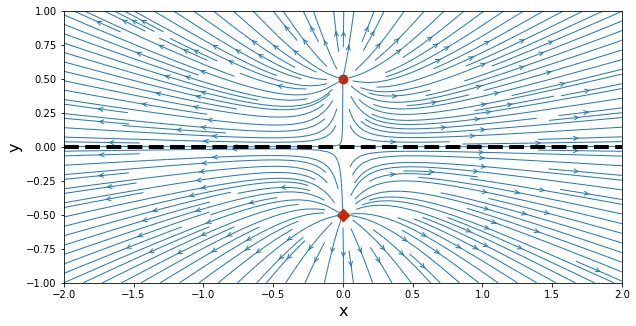

In [6]:
# суперпозиция источника и его отражения
u = source.u + source_image.u
v = source.v + source_image.v
psi = source.psi + source_image.psi

# рисуем линии тока
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1,\
                  arrowstyle='->')
pyplot.scatter(source.x, source.y, color='#CD2305', s=80, marker='o')
pyplot.scatter(source_image.x, source_image.y, color='#CD2305', s=80,\
               marker='D')
pyplot.axhline(0., color='k', linestyle='--', linewidth=4);

## Вихрь вблизи плоской поверхности

Аналогичным образом мы создадим еще один класс под названием `Vortex`, требуя в качестве данных его интенсивность и расположение. Класс будет иметь два метода: один для вычисления скорости вихря и другой, чтобы вычислить функцию тока.

И нам еще потребуется *constructor*, функция с именем `__init__` для того, чтобы инициализировать параметры вихря.

In [7]:
class Vortex:
    """
    Contains information related to a vortex.
    """
    def __init__(self, strength, x, y):
        """
        Sets the location and strength of the vortex.
        
        Parameters
        ----------
        strength: float
            Strength of the vortex.
        x: float
            x-coordinate of the vortex.
        y: float
            y-coordinate of the vortex.
        """
        self.strength = strength
        self.x, self.y = x, y
        
    def velocity(self, X, Y):
        """
        Computes the velocity field generated by a vortex.
        
        Parameters
        ----------
        X: 2D Numpy array of floats
            x-coordinate of the mesh points.
        Y: 2D Numpy array of floats
            y-coordinate of the mesh points.
        """
        self.u = +self.strength/(2*math.pi)*(Y-self.y)/((X-self.x)**2+\
                                                        (Y-self.y)**2)
        self.v = -self.strength/(2*math.pi)*(X-self.x)/((X-self.x)**2+\
                                                        (Y-self.y)**2)
        
    def stream_function(self, X, Y):
        """
        Computes the stream-function generated by a vortex.
        
        Parameters
        ----------
        X: 2D Numpy array of floats
            x-coordinate of the mesh points.
        Y: 2D Numpy array of floats
            y-coordinate of the mesh points.
        """
        self.psi = -self.strength/(4*math.pi)*numpy.log((X-self.x)**2+\
                                                        (Y-self.y)**2)

Теперь очень легко можно создать два объекта типа `Vortex`: собственно вихрь и его отражение.

In [8]:
strength_vortex = 1.0                  # интенсивность вихря
x_vortex, y_vortex = 0.0, 0.5          # положение вихря

# создаем вихрь и вычисляем для него скорости и функцию тока
vortex = Vortex(strength_vortex, x_vortex, y_vortex)
vortex.velocity(X, Y)
vortex.stream_function(X, Y)

# создаем отражение вихря и вычисляем для него скорости и функцию тока
vortex_image = Vortex(-strength_vortex, x_vortex, -y_vortex)
vortex_image.velocity(X, Y)
vortex_image.stream_function(X, Y)

Применяя принцип суперпозиции, мы можем получить линии тока, описывающие вихрь возле стены.

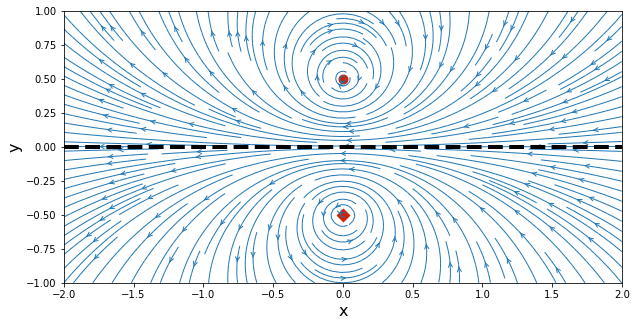

In [9]:
# суперпозиция вихря и его отражения
u = vortex.u + vortex_image.u
v = vortex.v + vortex_image.v
psi = vortex.psi + vortex_image.psi

# рисуем линии тока
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1,\
                  arrowstyle='->')
pyplot.scatter(vortex.x, vortex.y, color='#CD2305', s=80, marker='o')
pyplot.scatter(vortex_image.x, vortex_image.y, color='#CD2305', s=80,\
               marker='D')
pyplot.axhline(0., color='k', linestyle='--', linewidth=4);

## Движение вихревой пары у земли

Продолжаем веселье. Нужно больше особенностей! От пары вихрей может закружиться голова...

In [10]:
strength_vortex = 1.0                  # абсолютное значение интенсивности каждого вихря
x_vortex1, y_vortex1 = -0.1, 0.5       # положение первого вихря
x_vortex2, y_vortex2 = +0.1, 0.5       # положение первого вихря

# создаем два вихря в разных точках
vortex1 = Vortex(+strength_vortex, x_vortex1, y_vortex1)
vortex2 = Vortex(-strength_vortex, x_vortex2, y_vortex2)

# вычисляем скорости и функцию тока для каждого из вихрей
vortex1.velocity(X, Y)
vortex1.stream_function(X, Y)
vortex2.velocity(X, Y)
vortex2.stream_function(X, Y)

# создаем отражение каждого виxря
vortex1_image = Vortex(-strength_vortex, x_vortex1, -y_vortex1)
vortex2_image = Vortex(+strength_vortex, x_vortex2, -y_vortex2)

# вычисляем скорости и функцию тока для каждого из отражений
vortex1_image.velocity(X, Y)
vortex1_image.stream_function(X, Y)
vortex2_image.velocity(X, Y)
vortex2_image.stream_function(X, Y)

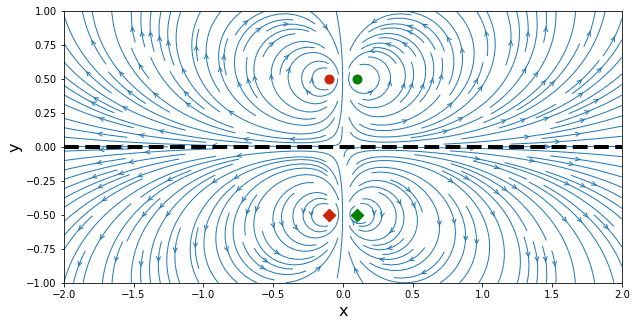

In [11]:
# суперпозиция пары вихрей и ее отражения
u = vortex1.u + vortex2.u + vortex1_image.u + vortex2_image.u
v = vortex1.v + vortex2.v + vortex1_image.v + vortex2_image.v
psi = vortex1.psi + vortex2.psi + vortex1_image.psi + vortex2_image.psi

# рисуем линии тока
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, \
                  arrowstyle='->')
pyplot.scatter(vortex1.x, vortex1.y, color='#CD2305', s=80, marker='o')
pyplot.scatter(vortex2.x, vortex2.y, color='g', s=80, marker='o')
pyplot.scatter(vortex1_image.x, vortex1_image.y, color='#CD2305', \
               s=80, marker='D')
pyplot.scatter(vortex2_image.x, vortex2_image.y, color='g', \
               s=80, marker='D')
pyplot.axhline(0., color='k', linestyle='--', linewidth=4);

## Диполь в потоке, параллельном плоскости

И напоследок ... диполь у плоской поверхности. Нам нужен новый класс, на этот раз под названием `Doublet`. Все так же, как и прежде!

In [12]:
u_inf = 1.0    # скорость равномерного течения

# вычисляем компоненты скорости и функцию тока для равномерного потока
u_freestream = u_inf * numpy.ones((N, N), dtype=float)
v_freestream = numpy.zeros((N, N), dtype=float)
psi_freestream = u_inf * Y

In [14]:
class Doublet:
    """
    Contains information related to a doublet.
    """
    def __init__(self, strength, x, y):
        """
        Sets the location and strength of the doublet.
        
        Parameters
        ----------
        strength: float
            Strength of the doublet.
        x: float
            x-coordinate of the doublet.
        y: float
            y-coordinate of the doublet.
        """
        self.strength = strength
        self.x, self.y = x, y
        
    def velocity(self, X, Y):
        """
        Computes the velocity field generated by a doublet.
        
        Parameters
        ----------
        X: 2D Numpy array of floats
            x-coordinate of the mesh points.
        Y: 2D Numpy array of floats
            y-coordinate of the mesh points.
        """
        self.u = -self.strength/(2*math.pi)*\
                ((X-self.x)**2-(Y-self.y)**2)/((X-self.x)**2+\
                                               (Y-self.y)**2)**2
        self.v = -self.strength/(2*math.pi)*\
                2*(X-self.x)*(Y-self.y)/((X-self.x)**2+\
                                         (Y-self.y)**2)**2
            
    def stream_function(self, X, Y):
        """
        Computes the stream-function generated by a doublet.
        
        Parameters
        ----------
        X: 2D Numpy array of floats
            x-coordinate of the mesh points.
        Y: 2D Numpy array of floats
            y-coordinate of the mesh points.
        """
        self.psi = -self.strength/(2*math.pi)*(Y-self.y)/((X-self.x)**2+\
                                                          (Y-self.y)**2)

In [15]:
strength_doublet = 1.0                # интенсивность диполя
x_doublet, y_doublet = 0.0, 0.3       # положение диполя

# создаем диполь (объект класса Doublet)
doublet = Doublet(strength_doublet, x_doublet, y_doublet)

# вычисляем поле скорости
# и функцию тока для диполя в узлах расчетной сетки
doublet.velocity(X, Y)
doublet.stream_function(X, Y)

# создаем отражение диполя
doublet_image = Doublet(strength_doublet, x_doublet, -y_doublet)

# вычисляем поле скорости
# и функцию тока для отражения диполя в узлах расчетной сетки
doublet_image.velocity(X, Y)
doublet_image.stream_function(X, Y)

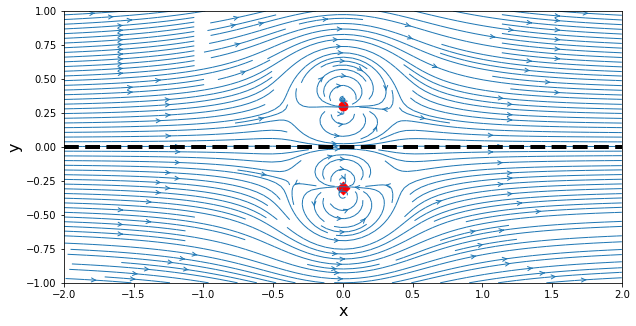

In [16]:
# суперпозиция диполя, его отражения и равномерного потока
u = u_freestream + doublet.u + doublet_image.u
v = v_freestream + doublet.v + doublet_image.v
psi = psi_freestream + doublet.psi + doublet_image.psi

# рисуем линии тока
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1,\
                  arrowstyle='->')
pyplot.scatter(doublet.x, doublet.y, color='r', s=80, marker='o')
pyplot.scatter(doublet_image.x, doublet_image.y, color='r', s=80,\
               marker='D')
pyplot.axhline(0., color='k', linestyle='--', linewidth=4);

---

In [20]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()